# Movie genre classification

**Introduction**

Le genre cinématographique permet de catégoriser les films en fonction des thèmes qu’ils abordent. Cette classification est omniprésente sur toutes les plateformes cinématographiques (Netflix, Canal+, Prime Video, OCS etc.) et sert même de repère au cinéphile. Les règles de classification de ne sont ni strictes ni définies pouvant rendre cette classification subjective. Cependant, il est commun de penser que l’histoire racontée par le film permet de le catégoriser dans un ou plusieurs genres. L’objectif de ce projet est donc de tenter de répondre à la question suivante : est-il possible de prédire le(s) genre(s) d’un film à partir de son synopsis ? 

Afin de répondre à cette question nous allons utiliser des techniques de Natural Language Processing (NLP) à partir de données récupérées sur le site français [Allociné](https://www.allocine.fr). 
Le fait de choisir ce site et non une base de données déjà constituée est intéressant selon nous pour deux raisons. Tout d’abord, cela rajoute un travail de construction de dataframe en utilisant des techniques de webscraping mais permettra également d’entrainer notre modèle sur des synopsis en langue française et non anglaise contrairement à plusieurs projets déjà réalisés dans ce domaine. 


**I. Dataframe creation**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time
from ast import literal_eval
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

from PIL import Image
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La première étape de notre travail est donc la construction de la base de données à partir des informations récupérées sur Allociné. Pour ce faire, nous avons analysé dans un premier temps les url associés à chaque film remarquant qu’ils se différenciaient uniquement par un nombre correspondant à leur identifiant (film/fichefilm_gen_cfilm=**6272**.html), nous permettant alors de parcourir les pages associées à chaque film en incrémentant ce même nombre. 

Ensuite, il nous fallait récupérer trois éléments : le titre du film, son synopsis et son/ses genre(s). Nous avons réalisé cela en étudiant la structure du code source afin de repérer les classes correspondantes. Les films peuvent parfois appartenir à plusieurs genres, c’est pourquoi nous les avons récupérés sous forme de liste afin de les faire tous apparaître dans le dataframe final. Ceci consiste donc à réaliser une classification multi-label.

Bien évidemment, certains identifiants ne correspondaient à aucun film (film supprimé ou simple choix de construction du site probablement) et renvoyaient une erreur facile à détecter (pas de titre de film sur la page par exemple).

Pour trouver ces identifiants, nous avons parcouru, dans un premier temps, la liste de [tous les films](https://www.allocine.fr/films/) sur Allociné. Chaque page contenait plusieurs films et donc leurs identifiants que nous avons stocké dans un fichier txt. Cette étape nous a permis de gagner du temps lors de la construction du dataframe car l'algorithme n'utilisait que des liens dirigeant effectivement vers un film.

Afin que vous puissiez faire l'essai sans perdre trop de temps, nous vous proposons de tester l'algorithme uniquement sur 10 pages de films (nous avons réalisé cette opération sur 2500 pages en réalité). 

In [2]:
def liste_url(nb_pages):
    f = open("liste.txt","a") 
    for i in range(0, nb_pages):
        page = 'https://www.allocine.fr/films/?page=' + str(i)
        resp = requests.get(page).text
        soup = BeautifulSoup(resp, 'html.parser')
        for a in soup.find_all('a', href=True):
            if a['href'][:25] == '/film/fichefilm_gen_cfilm':
                f.write((a['href'][26:-5]) + "\n")
    f.close()

liste_url(10)

Nous réutilisons le fichier texte précedemment construit en veillant à ce qu'il n'y ait pas de doublons. 

Pour nous assurer d'utiliser des variables intéressantes, nous avons choisi de sélectionner uniquement les films dont le synopsis contient plus de 250 caractères.

In [3]:
def create_dataframe(n):
    f= open("liste.txt","r")
    l = f.readlines()
    f.close()
    for i in range(len(l)):
        l[i]=int(l[i][:-1])
    l = sorted(list(set(l)))
    donnees = []
    i = 0
    start = time.time()
    while len(donnees) < n: 
        if len(donnees) >= 1 and (len(donnees)/n)*1000 == int((len(donnees)/n) * 1000):
            delta = time.time() - start
            clear_output(wait = True)
            minutes = int(delta * (n-len(donnees)) / len(donnees) // 60)
            secondes = int(delta * (n-len(donnees)) / len(donnees) % 60)
            print(round((len(donnees)/n)*100,2), '%'
                  , 'Estimated time remaining :', minutes, 'minutes and ', secondes, 'seconds')
        i+=1
        page = 'http://www.allocine.fr/film/fichefilm_gen_cfilm='+str(l[i])+'.html'
        resp = requests.get(page).text
        soup = BeautifulSoup(resp, 'html.parser')
        title = soup.find("div", {"class":"titlebar-title titlebar-title-lg"})
        if title == None: 
            continue
        else :
            section = soup.find("section", {"class": "section ovw ovw-synopsis"})
            synopsis = section.find("div", {"class":"content-txt"})
            if synopsis == None: 
                continue
            synopsis = synopsis.text.strip()
            if len(synopsis) < 250:
                continue
            genres = soup.find_all("span", {"class" : lambda value: value and value.startswith("ACrL2ZACrpbG1zL2")})
            genres_multi = []
            for ele in genres: 
                genres_multi.append(ele.text.strip())
            donnees.append([title.text.strip(),synopsis,genres_multi])
    df = pd.DataFrame(donnees, columns=['Titre', 'Synopsis','Genre(s)'])
    clear_output(wait=True)
    print('Création achevée')
    return df, i


Nous avons créé un dataframe de plus de 20000 films mais cela demande beaucoup de temps. Nous proposons donc ci-dessous de reproduire cette étape avec 10 films seulement afin de vérifier que notre algortithme fonctionne. L'indice i correspond au nombre présent dans l'url du dernier film récupéré, élément très utile pour éviter les doublons lorsque nous construisions notre dataframe "par morceaux". 

In [4]:
df, i = create_dataframe(10)

Création achevée


**II. Visualization**

In [5]:
df = pd.read_csv("df.csv")

Une fois notre dataframe constitué des colonnes « titre », « synopsis » et « genre(s) », nous pouvions le représenter plus en détails afin d'avoir une idée de la répartition des données en fonction de plusieurs critères. Nous avons commencé par créer un dictionnaire contenant tous les genres présents dans notre dataframe et avons représenté leur répartition en fonction du nombre de films. 

In [6]:
dic_genres = {'Drame': 0,
              'Comédie': 1,
              'Thriller': 2,
              'Action': 3,
              'Romance': 4,
              'Comédie dramatique': 5,
              'Documentaire': 6,
              'Aventure': 7,
              'Policier': 8,
              'Epouvante-horreur': 9,
              'Fantastique': 10,
              'Animation': 11,
              'Science fiction': 12,
              'Famille': 13,
              'Historique': 14,
              'Biopic': 15,
              'Guerre': 16,
              'Musical': 17,
              'Western': 18,
              'Divers': 19,
              'Erotique': 20,
              'Comédie musicale': 21,
              'Espionnage': 22,
              'Arts Martiaux': 23,
              'Judiciaire': 24,
              'Sport event': 25,
              'Bollywood': 26,
              'Expérimental': 27,
              'Péplum': 28,
              'Concert': 29,
              'Opera': 30,
              'Show': 31,
              'Drama': 32,
              'Dessin animé': 33}

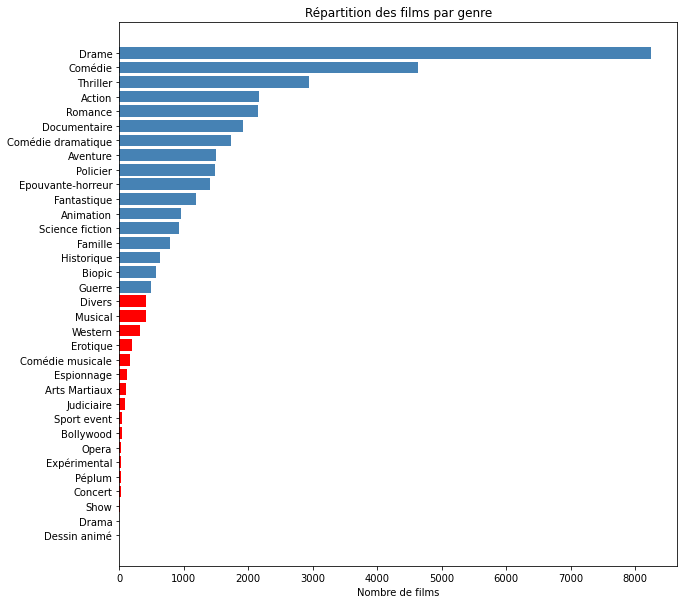

In [7]:
def histogramme(df):
  dic_nb_genres = {}

  for i, row in df.iterrows():
      for genre in literal_eval(row['Genre(s)']):
          if genre in dic_nb_genres:
              dic_nb_genres[genre] += 1
          else:
              dic_nb_genres[genre] = 1

  dic_nb_genres = {k: v for k, v in sorted(dic_nb_genres.items(), key=lambda item: item[1], reverse=False)}
  plt.figure(figsize=(10, 10))
  colors = ['r'] * 17 + ['steelblue'] * 17
  plt.barh(list(dic_nb_genres.keys()), dic_nb_genres.values(), color=colors)
  plt.title('Répartition des films par genre')
  plt.xlabel('Nombre de films')
  plt.show()

histogramme(df)

A noter que certains films sont classés dans plusieurs genres. Un film "Aventure/Policier" sera donc comptabilisé deux fois dans notre histogramme (la somme totale des films dépasse donc naturellement la taille du dataframe).
Ces premiers résultats nous indique que, comme sur Allociné, certains genres sont peu représentés dans notre dataframe (cf. [tous les films](https://www.allocine.fr/films/)). Afin d’assurer un entraînement performant de notre modèle, nous avons décidé de ne garder que les genres représentés au moins par 400 films (en bleu sur l'histogramme), éliminant ainsi 17 genres (en rouge) sur les 34 initiaux. 

In [8]:
def genres_selection(df):
    for i,row in df.iterrows():
        for genre in literal_eval(row['Genre(s)']):
            if dic_genres[genre]>16: 
                df.drop(i,inplace=True)
                break
  
genres_selection(df)

Les liens existant entre les genres (on retrouve très souvent drame et romance ensemble par exemple) pourraient nous aider à entrainer notre algorithme et améliorer les prédictions. C'est pourquoi, nous avons représenté ci-dessous un réseau contenant des traits plus ou moins épais en fonction de la fréquence des associations entre les différents genres. 
Les triples associations étant très difficilement visualisables, nous avons choisi de compter ces films 3 fois (ex : "Aventure / Policier / Drame" fera appraitre les 3 "doubles-liens"). 

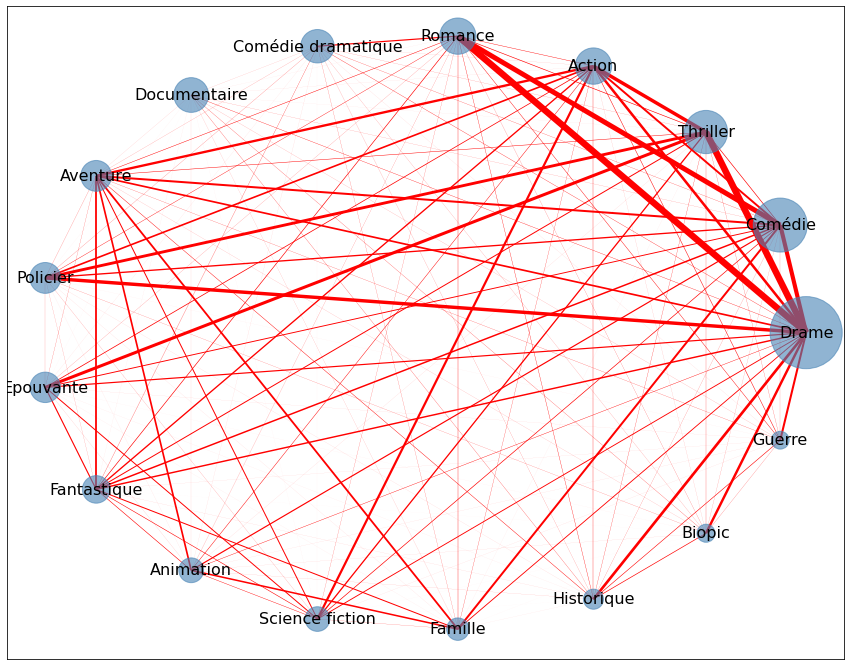

In [9]:
def reseau_genres(df, dic_genres):
  '''
      Représentation des liens entre les genres sous forme de réseau
  '''
  mat = np.zeros((17,17), dtype=int)

  for _, row in df.iterrows():
      genres = literal_eval(row['Genre(s)'])
      for i in range(len(genres)):
          for j in range(i,len(genres)):
              x = dic_genres[genres[i]]
              y = dic_genres[genres[j]]
              if x>y :
                  x, y = y, x
              mat[x,y] += 1

  plt.figure(figsize=(15,12))

  G = nx.Graph()
  for i in range(16):
      for j in range(i+1,17):
          G.add_edge(i,j,color='r',weight=mat[i,j]/150)

  pos = nx.circular_layout(G)

  edges = G.edges() 
  colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight'] for u,v in edges]
  node_size = [mat[i,i]/1.5 for i in range(17)]

  options = {"alpha": 0.6}
  nx.draw_networkx_nodes(G, pos, node_color="steelblue", node_size=node_size, **options)

  nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights)

  labels = {}
  labels[0] = 'Drame'
  labels[1] = 'Comédie'
  labels[2] = 'Thriller'
  labels[3] = 'Action'
  labels[4] = 'Romance'
  labels[5] = 'Comédie dramatique'
  labels[6] = 'Documentaire'
  labels[7] = 'Aventure'
  labels[8] = 'Policier'
  labels[9] = 'Epouvante'
  labels[10] = 'Fantastique'
  labels[11] = 'Animation'
  labels[12] = 'Science fiction'
  labels[13] = 'Famille'
  labels[14] = 'Historique'
  labels[15] = 'Biopic'
  labels[16] = 'Guerre'

  nx.draw_networkx_labels(G, pos, labels, font_size=16)
  plt.show()

reseau_genres(df, dic_genres)

Ces premières étapes de visualisation de genres ayant été effectuées, nous pouvions nous concentrer sur la variable principale de notre projet : le synopsis. Afin de rendre nos données utilisables, nous avons utilisé des techniques classiques de « nettoyage » et de réduction de texte en retirant les accents et la ponctuation mais également les mots "inutiles" à l’aide de stopwords. Sur ce dernier point, en plus des mots déjà inclus dans le module Stopwords, nous avons supprimé les mots qui apparaissaient trop souvent car ils nuieraient à la performance de notre modèle (ex = "tout", "plus"). Nous avons fixé la limite à 4000 occurences, de manière empirique, avec la volonté de garder des mots comme "femme" qui nous semblaient importants pour l'entraînement du modèle et ce, même s'ils apparaissaient très souvent. 

In [10]:
def clean_text(s):
    return s.replace("’"," ").replace("'"," ").replace('"'," ").replace(".", " ").replace(":", " ").replace("?"," ").replace('!',' ').replace(","," ").replace("é","e").replace('é','e').replace("è","e").replace("ê","e").replace("à","a").replace("ù","u").replace("û","u").replace("ü","u").replace("ï",'i').replace("â","a").replace("ç","c").replace("ï","i").replace('…',' ').replace('(',' ').replace(')',' ').replace("\r", " ").replace('\n',' ').replace('\xa0',' ').lower().split(" ")


In [11]:
df['Synopsis'] = df['Synopsis'].apply(clean_text)

In [12]:
def ban_words(df, limit_inf=-np.inf, limit_sup=3400, stemming=True):
    
    french_stopwords = list(set(stopwords.words('french')))
    banned_words = []

    for word in french_stopwords:
        word = word.replace("é","e").replace("è","e").replace("ê","e").replace("à","a").replace("ù","u").replace("û","u").replace("ç","c").replace("ï","i")
        if stemming : 
          banned_words.append(stemmer.stem(word))
        else :
          banned_words.append(word)

    dic = {}

    for i, row in df.iterrows():
        l = row['Synopsis']
        for k, word in enumerate(l):
            if len(word) <= 2:
                continue
            if not(word in l[:k]):
                if word in dic:
                    dic[word] += 1
                else:
                    dic[word] = 1

    banned_words += [k for k,v in dic.items() if (v <= limit_inf or v > limit_sup)]
    return banned_words

banned_words = ban_words(df, stemming=False)

Après ces premiers nettoyages, nous voulions être certains que les mots toujours présents dans les synopsis étaient cohérents avec le(s) genre(s) en question. C'est pourquoi, nous avons représenté, pour chaque genre, un nuage de mots dont la taille est proportionnelle à leur nombre d'occurence dans les synopsis du genre choisi. 

In [13]:
def words_genre(df, dic_genres, banned_words):
  l_dico = []
  for k in range (17):
      l_dico.append({})

  for i, row in df.iterrows():
      l = row['Synopsis']
      lst = []
      for genre in literal_eval(row['Genre(s)']):
          if dic_genres[genre] <= 16 : 
              lst.append(dic_genres[genre])
      for k, word in enumerate(l):
          if not((len(word) <= 2) or (word in banned_words) or (word in l[:k])):
              for p in lst:
                  if word in l_dico[p]:
                      l_dico[p][word] += 1
                  else:
                      l_dico[p][word] = 1
  return l_dico

l_dico = words_genre(df, dic_genres, banned_words)

In [14]:
def world_cloud_mask(l_dico, num_genre, path):
    mask = np.array(Image.open(path))
    genre = [k  for (k, val) in dic_genres.items() if val == num_genre]
    wordcloud = WordCloud(background_color='white', mask = mask,
                          width=mask.shape[1],
                          height=mask.shape[0]
                          ).generate_from_frequencies(l_dico[num_genre])

    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Nuage de mots pour le genre '+'"'+genre[0]+'"', fontsize=20)
    plt.axis('off')
    plt.show()

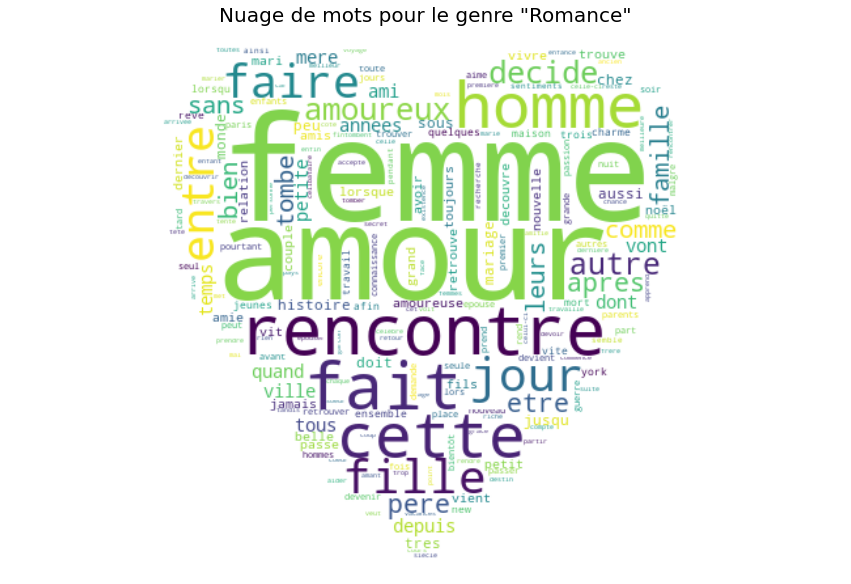

In [15]:
world_cloud_mask(l_dico, 4,'wordclouds_masks/romance.jpg')

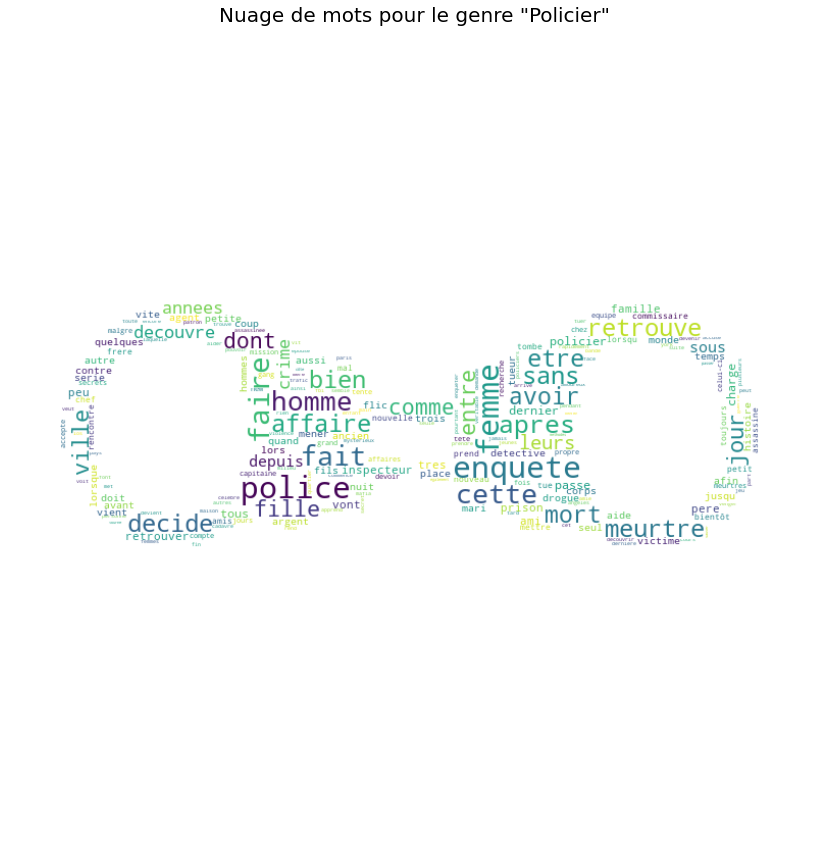

In [16]:
world_cloud_mask(l_dico, 8,'wordclouds_masks/policier.jpg')

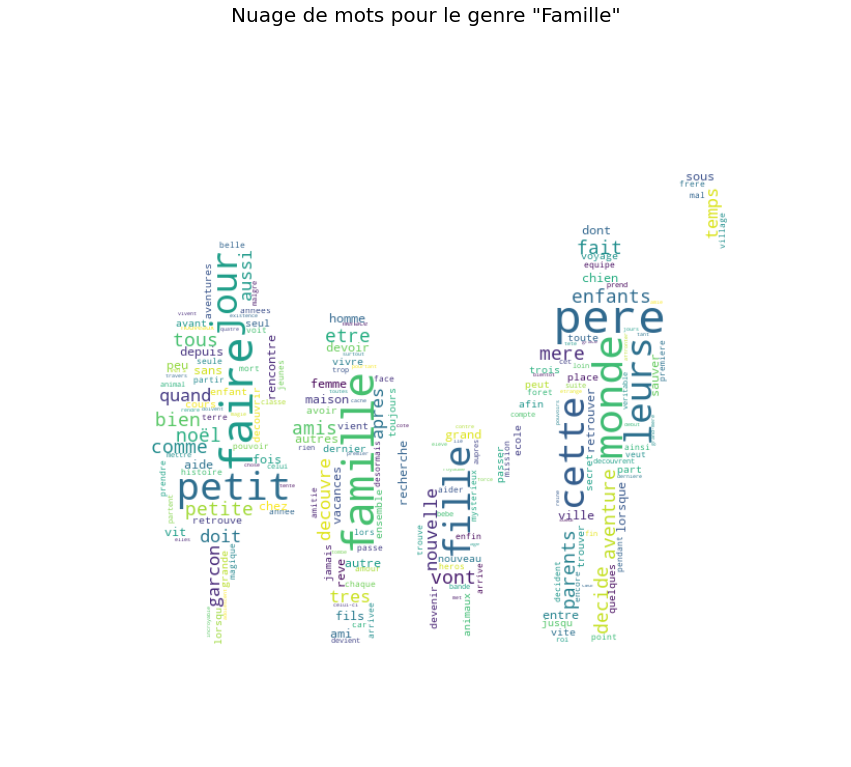

In [17]:
world_cloud_mask(l_dico, 13,'wordclouds_masks/famille.png')

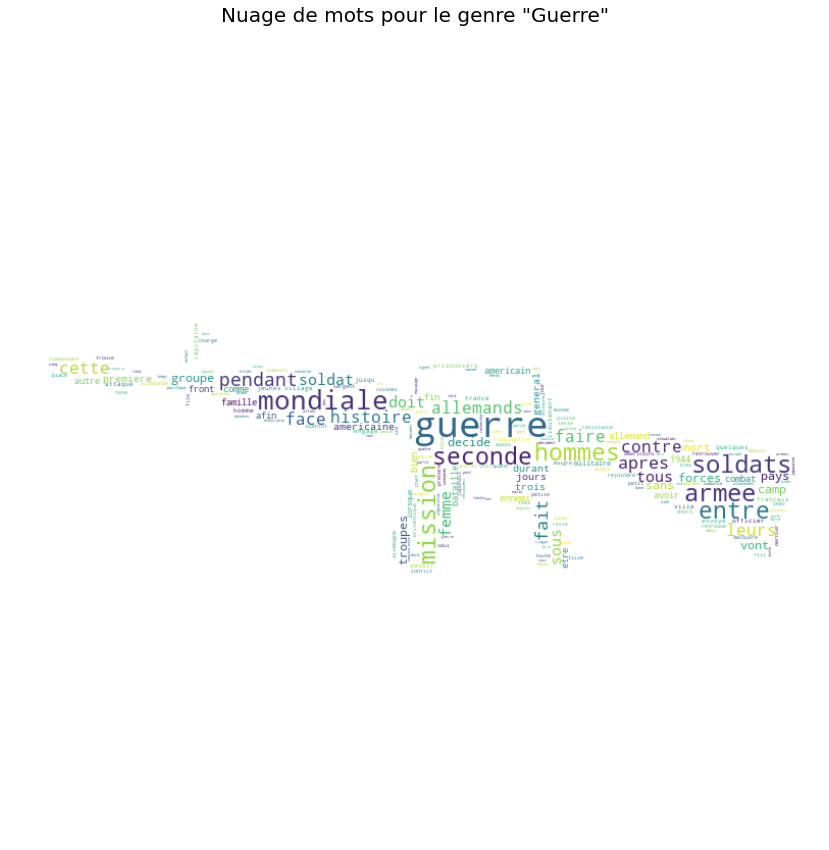

In [18]:
world_cloud_mask(l_dico,16,'wordclouds_masks/guerre.png')

Par simple curiosité, nous voulions savoir si la loi de Zipf était vérifiée sur notre dataframe et il semble que ce soit le cas d'après la figure ci-dessous. 

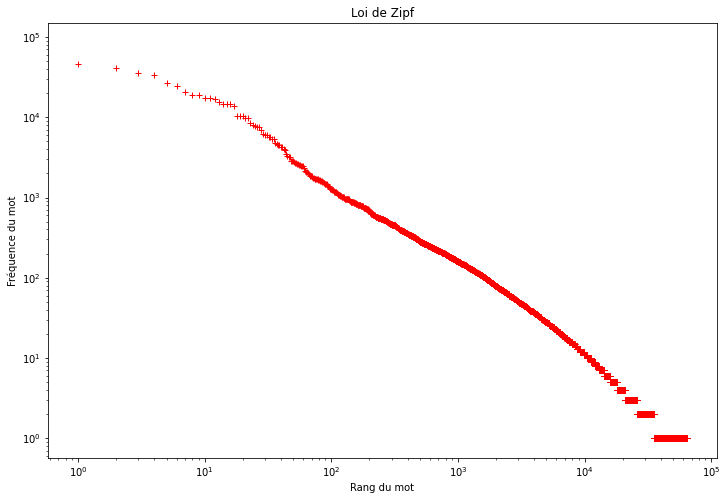

In [19]:
def draw_Zipf(df) : 
  dic_words_zipf = {}
  for i, row in df.iterrows():
    for word in row['Synopsis']:
        if len(word) > 1:
            if word in dic_words_zipf:
                dic_words_zipf[word]+= 1
            else:
                dic_words_zipf[word] = 1
                
  l_occur = sorted(list((dic_words_zipf.values())), reverse=True)
  lx = [i for i in range(len(l_occur))]
  plt.figure(figsize=(12,8))
  plt.xscale('log')
  plt.yscale('log')
  plt.plot(lx,l_occur,'r+')
  plt.xlabel('Rang du mot')
  plt.ylabel('Fréquence du mot')
  plt.title('Loi de Zipf')
  plt.show()

draw_Zipf(df)

**III. Modelisation**

Les étapes de visualisation étant terminées, nous passons à la modélisation.
Pour ce faire, nous commençons par utiliser un stemmer afin de regrouper les mots du synopsis en fonction de leur racine. Nous voulions utiliser un Lemmatizer français mais cela n'améliorait pas nos résultats. En effet, celui-ci ne regroupait pas suffisament les mots entre eux. Cela est peut être dû à la langue française en elle même ou au nombre de mots, probablement trop faible, que nous utilisons.


In [20]:
def stem_list(l):
    res = []
    for word in l:
        res.append(stemmer.stem(word))
    return res

In [21]:
df['Synopsis'] = df['Synopsis'].apply(stem_list)

Afin de rendre les genres interprétables par la machine, nous les convertissons en dummies.

In [22]:
def genres_to_vec(l):
    res = [0] * 17
    for genre in literal_eval(l):
        res[dic_genres[genre]] = 1
    return res

In [23]:
df['Genre(s)'] = df['Genre(s)'].apply(genres_to_vec)

En vue d'entraîner notre modèle, nous séparons notre dataframe en deux parties en conservant 20% des données pour le test.

In [24]:
train, test = train_test_split(df, test_size=0.2, random_state=7)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

Le prochain objectif est de créer la matrice tf-idf. Nous souhaitions bien comprendre la construction d'une telle matrice, c'est pourquoi, nous avons décidé de la créer nous même, bien que celle-ci soit déjà implémentée dans sklearn. 
Pour ce faire, nous construisons la fonction compute_hash qui a pour objectif de donner un identifiant numérique à chaque mot. 
La seconde fonction create_hash, parcourt le dataframe afin de répertorier les mots selon les critères suivants : None si le mot est dans "ban_words" et un identifiant, unique cette fois, sinon. Cet identifiant correpond à la colonne dans la matrice tf-idf. 

In [25]:
def compute_hash(word):
    res = 0
    for i, letter in enumerate(word):
        res += 7 ** (len(word) - i) * (ord(letter) - 97)
    return res % 4096

In [26]:
def create_hash(df):
    l_hash = [None] * 4096
    index = 0
    l_words = []
    
    banned_words = ban_words(df,10,3400,True)

    for word in banned_words:
        if len(word) > 2:
            buf = compute_hash(word)
            if l_hash[buf] == None:
                l_hash[buf] = {}
            if not(word in l_hash[buf]):
                l_hash[buf][word] = None


    for i, row in df.iterrows():
        l = row['Synopsis']
        for word in l:
            if len(word) > 2:
                buf = compute_hash(word)
                if l_hash[buf] == None:
                    l_hash[buf] = {}
                if not(word in l_hash[buf]):
                    l_hash[buf][word] = index
                    l_words.append(word)
                    index += 1
                    
    return l_hash, index

Ensuite, il nous fallait créer les fonctions tfidf selon le principe usuel. La première fonction sera appliquée au dataframe d'entraînement et la seconde, reprenant les résultats de la première, sera appliquée au dataframe de test. 

In [27]:
def create_tfidf(df):
    l_hash, index = create_hash(df)
    mat = np.zeros((len(df), index), dtype=int)
    l_presence = [0] * index
    l_len = [0] * len(df)
    for i, row in df.iterrows():
        l = row['Synopsis']
        for k, word in enumerate(l):
            if len(word) > 2:
                buf = compute_hash(word)
                ind = l_hash[buf][word]
                if ind != None:
                    l_len[i] += 1
                    mat[i, ind] += 1
                    if not(word in l[:k]):
                        l_presence[ind] += 1
    mat_tfidf = np.zeros((len(df), index))
    n = len(df)

    for i, row in df.iterrows():
        l = row['Synopsis']
        for k, word in enumerate(l):
            if len(word) > 2:
                buf = compute_hash(word)
                ind = l_hash[buf][word]
                if ind != None:
                    mat_tfidf[i, ind] = mat[i, ind] / l_len[i] * math.log(n/l_presence[ind])
    
    return mat_tfidf, l_hash, index

In [28]:
def create_tfidf_test(df, l_hash, index):
    
    mat = np.zeros((len(df), index), dtype=int)
    l_presence = [0] * index
    l_len = [0] * len(df)

    for i, row in df.iterrows():
        l = row['Synopsis']
        for k, word in enumerate(l):
            if len(word) > 2:
                buf = compute_hash(word)
                if l_hash[buf] != None and word in l_hash[buf]:
                    ind = l_hash[buf][word]
                    if ind != None:
                        l_len[i] += 1
                        mat[i, ind] += 1
                        if not(word in l[:k]):
                            l_presence[ind] += 1
    mat_tfidf = np.zeros((len(df), index))
    n = len(df)

    for i, row in df.iterrows():
        l = row['Synopsis']
        for k, word in enumerate(l):
            if len(word) > 2:
                buf = compute_hash(word)
                if l_hash[buf] != None and word in l_hash[buf]:
                    ind = l_hash[buf][word]
                    if ind != None:
                        mat_tfidf[i, ind] = mat[i, ind] / l_len[i] * math.log(n/l_presence[ind])
    
    return mat_tfidf

In [29]:
X_train, l_hash, index = create_tfidf(train)
X_test = create_tfidf_test(test, l_hash, index)

In [30]:
def y_mat(df):
    y = np.zeros((len(df), 17), dtype=int)
    for i, row in df.iterrows():
        y[i,:] = row['Genre(s)']
    return y

In [31]:
y_train = y_mat(train)
y_test = y_mat(test)

Nous avons défini les métriques usuelles nous permettant de comparer nos différents modèles mais également les performances de prédictions en fonction des genres. A noter que nous travaillons en multi-label, ces métriques doivent donc être adapatées. En effet, il est par exemple plus satisfaisant de prédire 2 genres sur 3 que 0 sur 3. Ces métriques prennent donc en compte ces différents degrés de réussite d'une prédiction.

In [32]:
def precision(y_pred, y):
    res = 0
    if len(y.shape) == 1:
        for i in range(len(y)):
            res += y_pred[i] * y[i]
        res /= max(sum(y_pred),1)
    else:
        n = y.shape[1]
        for i in range(len(y)):
            res +=  sum(abs(y_pred[i,:] * y[i,:])) / max(sum(y_pred[i,:]),1)
        res /= len(y)
    return res

In [33]:
def recall(y_pred, y):
    res = 0
    if len(y.shape) == 1:
        for i in range(len(y)):
            res += y_pred[i] * y[i]
        res /= sum(y)
    else:
        n = y.shape[1]
        for i in range(len(y)):
            res += sum(abs(y_pred[i,:] * y[i,:])) / max(sum(y[i,:]),1)
        res /= len(y)
    return res

In [34]:
def F1_score(y_pred, y):
    rec = recall(y_pred, y)
    prec = precision(y_pred, y)
    return 2 * (rec * prec) / (rec + prec)

Dans un premier temps, nous comparons différents classificateurs genre par genre. Cela signifie que nous réduisons le problème à un travail de classification binaire d'appartenance à un genre. En faisant ça pour les 17 genres, et en ayant préalablement optimisé les hyperparamètres sur un dataset de validation nous obtenons les résultats suivants :

In [35]:
models = [SVC(kernel='sigmoid',max_iter=100, random_state=0),
          LogisticRegression(random_state=0, class_weight='balanced', max_iter=50, solver='liblinear', C=0.2),
          RandomForestClassifier(random_state=0, n_estimators=200, max_depth=3, class_weight='balanced')]

name_models = ['SVC', 'Logistic Regression', 'Random Forest']

columns = list(dic_genres.keys())[:17] + ['Mean']

def compare_models(models):
    res = np.zeros((len(models), 18))
    for j, clf in enumerate(models):
      l_res = []
      for i in range(17):
        print(i, clf)
        clf.fit(X_train, y_train[:,i])
        y_pred = clf.predict(X_test)
        l_res.append(F1_score(y_pred, y_test[:,i]))
      l_res.append(np.mean(l_res))
      res[j, :] = l_res
    res = pd.DataFrame(res, columns=columns)
    res['Model Name'] = name_models
    res = res[['Model Name'] + columns]
    return res

res = compare_models(models)
res

0 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


1 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


2 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


3 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


4 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


5 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


6 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


7 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


8 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


9 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


10 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


11 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


12 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


13 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


14 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


15 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


16 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=100, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0 LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
1 LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
2 LogisticRegression(C=0.2, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False

,Model Name,Drame,Comédie,Thriller,Action,Romance,Comédie dramatique,Documentaire,Aventure,Policier,Epouvante-horreur,Fantastique,Animation,Science fiction,Famille,Historique,Biopic,Guerre,Mean
0,SVC,0.509666,0.368830,0.241807,0.217238,0.194413,0.156368,0.295964,0.185729,0.192935,0.196170,0.170147,0.109830,0.158504,0.144673,0.075978,0.081013,0.195599,0.205580
1,Logistic Regression,0.632362,0.570922,0.473548,0.524370,0.394435,0.255596,0.662996,0.459152,0.485958,0.552927,0.314634,0.423676,0.526112,0.377600,0.322581,0.300752,0.520635,0.458721
2,Random Forest,0.582032,0.485597,0.406317,0.457438,0.389761,0.215303,0.577681,0.370137,0.451444,0.436860,0.322237,0.350725,0.429134,0.322368,0.253112,0.224939,0.543478,0.401092


Nous remarquons alors que le modèle de régression logistique obtient les meilleures performances,  nous le choisissons donc pour la suite. Cependant ce modèle ne supporte pas directement le problème de multi-label, nous devons donc l'adapter.

Nous allons empiler des classificateurs pour réaliser cette tâche. En effet, considérer que les résultats de la classification multi-label ne seraient qu'une concaténation des résultats sur des classificateurs conduirait à une perte d'information. Comme observé dans la partie visualisation, les possibilités de liaison sont assez spécifiques, par exemple nous avons remarqué que "Documentaire" était souvent seul, ou encore que "Epouvante" et "Thriller" vont bien ensemble. On en conclut donc que, connaissant les résultats sur un certain genre, cela peut permettre d'aider à la classification d'un autre genre. 

On utilise donc la structure la "Stacking Structure" expliquée dans ce [papier](http://palm.seu.edu.cn/xgeng/files/fcs18.pdf). Cela consiste à construire deux couches de *n* classificateurs où *n* est le nombre de genres. La première couche est constituée de classificateurs binaires utilisant uniquement la matrice *td-idf*. La deuxième couche est elle aussi constituée de classificateurs binaires qui utilisent cette fois la matrice *tf-idf* ainsi que les résultats de la première couche.

In [36]:
class LogisticRegression_MultiLabel:
    
    def __init__(self, max_iter, C1, C2, random_state, solver='liblinear'):
        self.max_iter = max_iter
        self.C1 = C1
        self.C2 = C2
        self.class_weight = 'balanced'
        self.random_state = random_state
        self.solver = solver
        self.l_clf1 = None
        self.l_clf2 = None
        self.nb_genres = None
        
        
    def fit(self, X, y):
        nb_genres = y.shape[1]
        self.nb_genres = nb_genres
        buf = np.concatenate([X,y], axis=1)
        
        mat_pred = np.zeros((X.shape[0],nb_genres))
        l_clf1 = []
        for i in range(nb_genres):
            clf1 = LogisticRegression(random_state=self.random_state, class_weight=self.class_weight, max_iter=self.max_iter, solver=self.solver, C=self.C1)
            clf1.fit(X, y[:,i])
            l_clf1.append(clf1)
            prob = clf1.predict_proba(X)[:,1]
            mat_pred[:,i] = prob
        mat_pred = np.concatenate([mat_pred, X], axis=1)
        self.l_clf1 = l_clf1
        
        l_clf2 = []
        for i in range(nb_genres):
            clf2 = LogisticRegression(random_state=self.random_state, class_weight=self.class_weight, max_iter=self.max_iter, solver=self.solver, C=self.C2)
            clf2.fit(mat_pred, y[:,i])
            l_clf2.append(clf2)
        self.l_clf2 = l_clf2    
        
        
    def predict(self, X):
        res = np.zeros((X.shape[0], self.nb_genres))
        mat_test = np.zeros((X.shape[0],self.nb_genres))
        
        for i in range(self.nb_genres):
            clf1 = self.l_clf1[i]
            prob = clf1.predict_proba(X)[:,1]
            mat_test[:,i] = prob
        mat_test = np.concatenate([mat_test, X], axis=1)
        
        for i in range(self.nb_genres):
            clf2 = self.l_clf2[i]
            pred = clf2.predict(mat_test)
            res[:,i] = pred
        
        return res 
        

De nouveau nous trouvons les hyperparamètres otpimaux sur un dataset de validation. Puis nous calculons les résultats de ce nouveau modèle sur le dataset de test.

In [37]:
clf = LogisticRegression_MultiLabel(200,0.5,2,0)
clf.fit(X_train, y_train)  
pred_LR = clf.predict(X_test)
res = []
for i in range(17):
  res.append(F1_score(pred_LR[:,i],y_test[:,i]))
res.append(np.mean(res))
columns = list(dic_genres.keys())[:17] + ['Mean']
res = pd.DataFrame([res], columns=columns)
res['Model Name'] = ['Logistic Regression Multi Label']
res = res[['Model Name'] + columns]
res

,Model Name,Drame,Comédie,Thriller,Action,Romance,Comédie dramatique,Documentaire,Aventure,Policier,Epouvante-horreur,Fantastique,Animation,Science fiction,Famille,Historique,Biopic,Guerre,Mean
0,Logistic Regression Multi Label,0.623345,0.573872,0.455182,0.541748,0.39001,0.221095,0.71564,0.455,0.466307,0.572674,0.320122,0.45738,0.541284,0.412556,0.371681,0.311688,0.591093,0.471805


Comme prévu, ce modèle améliore légérement les prédictions (+1% en moyenne). On remarque notamment (comme précédemment), un très bon score pour le genre "Documentaire". On peut expliquer cela par le fait que les synopsis de ce genre sont plus longs en moyenne que les autres et donc contiennent plus d'informations. 

En voyant cette structure, où les résultats de premiers classificateurs sont réexploités par d'autres classificateurs, on peut logiquement penser aux réseaux de neurones.

Nous avons donc essayé de mettre en place un réseau de neurones mais sans grand succès, puisque même après la recherche d'hyperparamètres, les résultats étaient toujours moins bons que ceux de notre Logistic Regression Multi-Label.

In [38]:
clf = MLPClassifier(hidden_layer_sizes=(100), random_state=0, max_iter=150, learning_rate_init=0.01, alpha=0.01)
clf.fit(X_train, y_train)
pred_MLP = clf.predict(X_test)
res = []
for i in range(17):
  res.append(F1_score(pred_MLP[:,i],y_test[:,i]))
res.append(np.mean(res))
columns = list(dic_genres.keys())[:17] + ['Mean']
res3 = pd.DataFrame([res], columns=columns)
res3['Model Name'] = ['MLP Classifier']
res3 = res3[['Model Name'] + columns]
res3


,Model Name,Drame,Comédie,Thriller,Action,Romance,Comédie dramatique,Documentaire,Aventure,Policier,Epouvante-horreur,Fantastique,Animation,Science fiction,Famille,Historique,Biopic,Guerre,Mean
0,MLP Classifier,0.551362,0.49481,0.380414,0.484076,0.296719,0.12987,0.702312,0.409894,0.399194,0.46988,0.266979,0.414013,0.471338,0.227451,0.234637,0.119403,0.541935,0.387899


On observe en effet que la moyenne chute très nettement avec ce modèle. En regardant plus en détail, on remarque que tous les genres sont moins bien prédits même si les prédictions pour le genre "documentaire" restent très élevées par rapport aux autres. 

On va finalement comparer le MLPClassifier avec la Logistic Regression Multi-Label en utilisant l'extension des métriques : 

In [39]:
pd.DataFrame([['Logistic Regression Multi-Label', precision(pred_LR,y_test), recall(pred_LR,y_test), F1_score(pred_LR,y_test)],
              ['MLP Classifier', precision(pred_MLP,y_test), recall(pred_MLP,y_test), F1_score(pred_MLP,y_test)]],
             columns=['Classifier Name','Precision', 'Recall', 'F1 Score'])

,Classifier Name,Precision,Recall,F1 Score
0,Logistic Regression Multi-Label,0.455499,0.651897,0.536283
1,MLP Classifier,0.445087,0.447001,0.446042


La différence est une fois encore assez nette. En ce qui concerne la précision, les deux modèles sont assez similaires mais le recall est bien plus élevé pour la régression logistique multi-label. Cette dernière est donc plus performante dans l'identification des genres réels des films étudiés. 

**Conclusion**

L'objectif de ce projet était de savoir s'il était possible de prédire le(s) genre(s) d'un film à partir de son synopsis en français. Après un traitement des données qui nécessitait de fixer de manière empirique certains critères, appuyés par des étapes de visualisations préalablement réalisées, nous avons mis en place différents modèles pour tenter de répondre à cette question. 
Bien évidemment, les résultats ne sont pas pleinement satisfaisants, nous espérions obtenir des prédictions un peu meilleures. 

Néanmoins, nous avons remarqué que certains genres étaient plus facilement prédictibles notamment grâce à la longueur moyenne de leurs synopsis, aux mots régulièrement utilisés dans ceux-ci ou simplement parce qu'ils sont plus présents dans la réalité. En effet, les genres les plus représentés dans notre dataframe sont ceux dont les F1 Score figurent parmis les plus élévés (Drame ou Comédie). De plus, on remarque que des genres assez peu représentés mais dont les nuages de mots faisaient ressortir des mots "cohérents" présentent des F1 Score assez élevés (Guerre ou SF). Enfin, et cela est encore une fois cohérent, les genres peu représentés et dont les nuages de mots ne faisaient rien ressortir de particulier, sont assez mal prédits (Biopic, Historique ou Fantastique). A noter que les réesultats pour le genre "Documentaire" sont étonnant à première vue. En effet, il n'est que 6ème genre en nombre de films et son nuage de mot n'est pas aussi explicites que certains et il obtient un très bon score. 


Ainsi, il semble possible de prédire le genre d'un film à partir de son synopsis, mais, comme très souvent, le volume des données (nombre de film d'un même genre ou longueur des synopsis notamment) semble jouer un rôle essentiel. 